# Look at the AUG 1 flux tube UQ results

Applying various fitting schemes to the AUG 1 flux tube GEM data

- GPR
- various linear multivariate options
- various SVM options
- various degree polynomial multivariate options 

## A pretty standard set of imports

In [1]:
%matplotlib inline
#%matplotlib notebook
import os
import matplotlib
#if not os.getenv("DISPLAY"): matplotlib.use('Agg')
import matplotlib.pylab as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared, Matern, ConstantKernel
import pickle, gzip
import itertools
from timeit import default_timer as timer
import resource, sys
import functools
import operator

/tmp/ipykernel_49012/1565318038.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


## Read the data

In [2]:
filepath = '../../data/gem_uq_inoutput.csv'
filepath = '../../resuq_main_ti_transp_flux_all_moj202gj_11.csv'
G = pd.read_csv(filepath)
G.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,16.0,7.500000e+00,4.760952,0.000000e+00,3.750000e+00,7.500000e+00,1.125000e+01,1.500000e+01
name,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
te_value,16.0,5.510258e+02,32.856830,5.192123e+02,5.192123e+02,5.510258e+02,5.828393e+02,5.828393e+02
ti_value,16.0,6.397011e+02,38.144404,6.027679e+02,6.027679e+02,6.397011e+02,6.766343e+02,6.766343e+02
te_ddrho,16.0,-9.438055e+03,562.776857,-9.982961e+03,-9.982961e+03,-9.438055e+03,-8.893148e+03,-8.893148e+03
ti_ddrho,16.0,-9.185803e+03,547.735466,-9.716146e+03,-9.716146e+03,-9.185803e+03,-8.655460e+03,-8.655460e+03
ti_transp_flux,16.0,2.410740e+06,340744.282128,1.867451e+06,2.182214e+06,2.432694e+06,2.657536e+06,2.932325e+06
ti_transp_flux_std,16.0,4.155682e+05,124296.062992,2.512994e+05,3.155689e+05,4.138249e+05,4.926996e+05,7.388254e+05
ti_transp_flux_stem,16.0,2.847054e+05,143183.032476,7.069798e+04,1.729624e+05,2.339132e+05,4.271206e+05,5.194665e+05


In [3]:
G=G.drop('name',1)

/tmp/ipykernel_49012/475852022.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  G=G.drop('name',1)


# Transform the data

In [4]:
G.te_value = np.log10(G.te_value)
G.ti_value = np.log10(G.ti_value)
G.te_ddrho = np.log10(-G.te_ddrho)
G.ti_ddrho = np.log10(-G.ti_ddrho)
#G.te_transp_flux = np.log10(G.te_transp_flux)
G.ti_transp_flux = np.log10(G.ti_transp_flux)
G.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,16.0,7.500000,4.760952,0.000000,3.750000,7.500000,11.250000,15.000000
te_value,16.0,2.740447,0.025925,2.715345,2.715345,2.740447,2.765549,2.765549
ti_value,16.0,2.805252,0.025925,2.780150,2.780150,2.805252,2.830354,2.830354
te_ddrho,16.0,3.974157,0.025925,3.949056,3.949056,3.974157,3.999259,3.999259
ti_ddrho,16.0,3.962392,0.025925,3.937290,3.937290,3.962392,3.987494,3.987494
ti_transp_flux,16.0,6.377998,0.062382,6.271249,6.338882,6.386068,6.424386,6.467212
ti_transp_flux_std,16.0,415568.166317,124296.062992,251299.351002,315568.943854,413824.913316,492699.605459,738825.402934
ti_transp_flux_stem,16.0,284705.446653,143183.032476,70697.983210,172962.445898,233913.208029,427120.602313,519466.500311


## Examine correlations

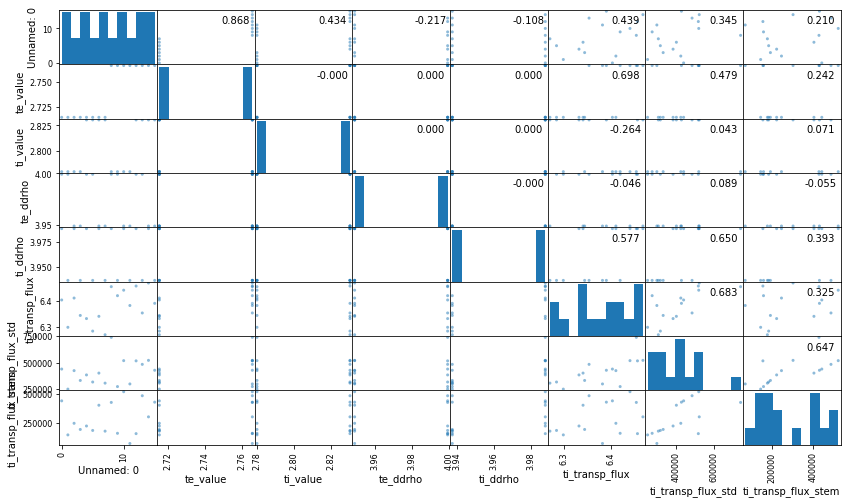

In [5]:
axes = pd.plotting.scatter_matrix(G, alpha=0.5, diagonal='hist', figsize=(14,8))
corr = np.array(G.corr())
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')
plt.show()

## Prepare for fitting

In [6]:
XLABELS = ['te_value', 'ti_value', 'te_ddrho', 'ti_ddrho']
X = G[XLABELS].values
#YLABELS = ['te_transp_flux', 'ti_transp_flux']
YLABELS = ['ti_transp_flux']
Y = G[YLABELS].values

## Fit the data using GPR

In [7]:
NX = len(XLABELS)
NY = len(YLABELS)
print('Number of points = ', X.shape[0])

kernel = ConstantKernel() + Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=1)

start=timer()
GP = []
for F in range(NY): 
    gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
#    %time 
    gp.fit(X, Y[:,F])
    print(YLABELS[F], gp.kernel_)
    GP.append(gp)
end=timer()
print('Calculating GPR took %0.3f seconds' % (end-start))


Number of points =  16
ti_transp_flux 0.00316**2 + Matern(length_scale=1e-05, nu=1.5) + WhiteKernel(noise_level=0.000973)
Calculating GPR took 0.255 seconds


/u/yyudin/conda-envs/python394/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/u/yyudin/conda-envs/python394/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


## Calculate the data at the fit points

In [8]:
start=timer()
Xt = X.copy()
Yt = np.zeros((Xt.shape[0],NY))
Yts = np.zeros((Xt.shape[0],NY))
for F in range(NY):
  Yt[:,F], Yts[:,F] = GP[F].predict(Xt, return_std=True)
end=timer()
print('Calculating GPR on grid took %0.3f seconds' % (end-start))

Calculating GPR on grid took 0.030 seconds


RMSE at the points (should be small) and mean of the predicted variance at the points

In [9]:
print('RMSE =', np.sqrt((Y-Yt)**2).mean(axis=0))

RMSE = [5.08786087e-05]


In [10]:
print('Means of predicted variance =', Yts.mean(axis=0))

Means of predicted variance = [0.00266428]


## Prepare to plot the data along various cuts

In [11]:
Xvals = np.array([np.unique(X[:,i]) for i in range(X.shape[1])])

In [12]:
def vis(slice, axis=None):
    if slice == 0:
        Xt = np.array([i for i in itertools.product(np.linspace(Xvals[0].min(), Xvals[0].max(), 100), 
                                                    [Xvals[1,2]], 
                                                    [Xvals[2,2]],
                                                    [Xvals[3,2]])])
    elif slice == 1:
        Xt = np.array([i for i in itertools.product([Xvals[0,2]], 
                                                    np.linspace(Xvals[1].min(), Xvals[1].max(), 100), 
                                                    [Xvals[2,2]],
                                                    [Xvals[3,2]])])
    elif slice == 2:
        Xt = np.array([i for i in itertools.product([Xvals[0,2]], 
                                                    [Xvals[1,2]],
                                                    np.linspace(Xvals[2].min(), Xvals[2].max(), 100), 
                                                    [Xvals[3,2]])])
    elif slice == 3:
        Xt = np.array([i for i in itertools.product([Xvals[0,2]], 
                                                    [Xvals[1,2]],
                                                    [Xvals[2,2]],
                                                    np.linspace(Xvals[3].min(), Xvals[3].max(), 100))])
    Yt = np.zeros((Xt.shape[0],NY))
    Yts = np.zeros((Xt.shape[0],NY))
    for F in range(NY):
      Yt[:,F], Yts[:,F] = GP[F].predict(Xt, return_std=True)
    
    if axis is None:
        fig, axis = plt.subplots(figsize=(8,6))
    axis.plot(10.0**(Xt[:,slice]), 10.0**(Yt[:,0]), 'r', label=YLABELS[0])
    axis.fill_between(10.0**(Xt[:,slice]), 10.0**(Yt[:,0]-Yts[:,0]), 10.0**(Yt[:,0]+Yts[:,0]), color='red', alpha=0.5)
    axis.plot(10.0**(Xt[:,slice]), 10.0**(Yt[:,1]), 'b', label=YLABELS[1])
    axis.fill_between(10.0**(Xt[:,slice]), 10.0**(Yt[:,1]-Yts[:,1]), 10.0**(Yt[:,1]+Yts[:,1]), color='blue', alpha=0.5)
    axis.set_xlabel(XLABELS[slice])
    #axis.set_legend(loc=0)
    axis.set_title("%s=%0.3f, %s=%0.3f, %s=%0.3f" % 
              functools.reduce(operator.concat, 
                               tuple([(XLABELS[i], 10.0**Xvals[i,2]) for i in range(len(XLABELS)) if i != slice])))

In [13]:
def vis2(slice, axis=None):
    if slice == 0:
        Xt = np.array([i for i in itertools.product(np.linspace(Xvals[0].min(), Xvals[0].max(), 100), 
                                                    [Xvals[1,1]], 
                                                    [Xvals[2,1]],
                                                    [Xvals[3,1]])])
    elif slice == 1:
        Xt = np.array([i for i in itertools.product([Xvals[0,1]], 
                                                    np.linspace(Xvals[1].min(), Xvals[1].max(), 100), 
                                                    [Xvals[2,1]],
                                                    [Xvals[3,1]])])
    elif slice == 2:
        Xt = np.array([i for i in itertools.product([Xvals[0,1]], 
                                                    [Xvals[1,1]],
                                                    np.linspace(Xvals[2].min(), Xvals[2].max(), 100), 
                                                    [Xvals[3,1]])])
    elif slice == 3:
        Xt = np.array([i for i in itertools.product([Xvals[0,1]], 
                                                    [Xvals[1,1]],
                                                    [Xvals[2,1]],
                                                    np.linspace(Xvals[3].min(), Xvals[3].max(), 100))])
    Yt = np.zeros((Xt.shape[0],NY))
    Yts = np.zeros((Xt.shape[0],NY))
    for F in range(NY):
      Yt[:,F], Yts[:,F] = GP[F].predict(Xt, return_std=True)
    
    if axis is None:
        fig, axis = plt.subplots(figsize=(8,6))
    axis.plot(10.0**(Xt[:,slice]), 10.0**(Yt[:,0]), 'r', label=YLABELS[0])
    axis.fill_between(10.0**(Xt[:,slice]), 10.0**(Yt[:,0]-Yts[:,0]), 10.0**(Yt[:,0]+Yts[:,0]), color='red', alpha=0.5)
    #axis.plot(10.0**(Xt[:,slice]), 10.0**(Yt[:,1]), 'b', label=YLABELS[1])
    #axis.fill_between(10.0**(Xt[:,slice]), 10.0**(Yt[:,1]-Yts[:,1]), 10.0**(Yt[:,1]+Yts[:,1]), color='blue', alpha=0.5)
    axis.set_xlabel(XLABELS[slice])
    #axis.set_legend(loc=0)
    axis.set_title("%s=%0.3f, %s=%0.3f, %s=%0.3f" % 
              functools.reduce(operator.concat, 
                               tuple([(XLABELS[i], 10.0**Xvals[i,0]) for i in range(len(XLABELS)) if i != slice])))

## Plot the data along various cuts

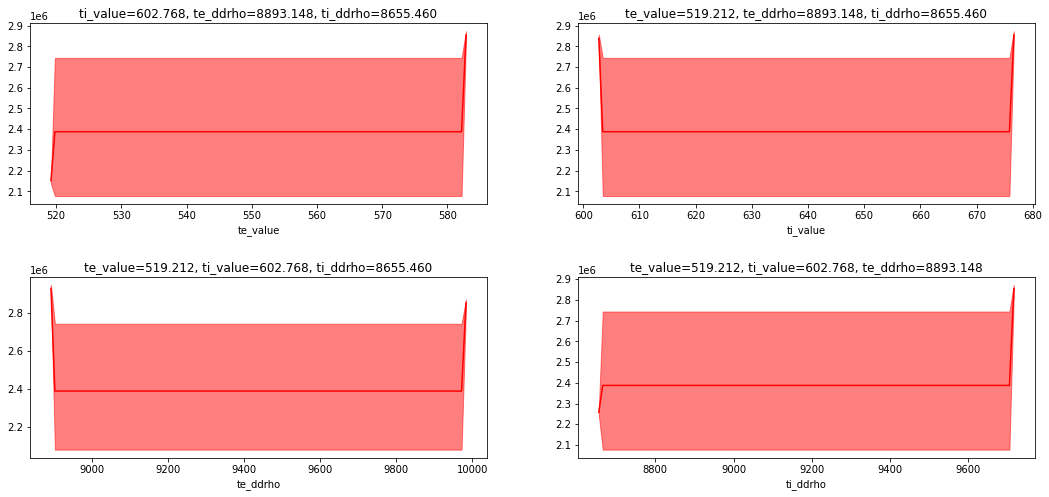

In [14]:
plt.figure(figsize=(18,8))
for i in range(NX):
    ax=plt.subplot(2,2,i+1)
    #vis(i, ax)
    vis2(i, ax)
plt.subplots_adjust(hspace=0.4)

## Scan over various fitting methods: imports

In [15]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import RANSACRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn import svm
import tabulate

### GPR

In [16]:
L=[]

Y_pred = np.zeros_like(Y)
for F in range(Y.shape[1]):
    Y_pred[:,F] = GP[F].predict(X, return_std=False)
print("Mean squared error: %.3f" % mean_squared_error(Y, Y_pred))
RMSE = np.sqrt(mean_squared_error(Y, Y_pred, multioutput='raw_values'))
print("RMSE ", RMSE)
# Explained variance score: 1 is perfect prediction
VarianceScore = r2_score(Y, Y_pred)
print('Variance score: %.3f' % VarianceScore)
L.append(['GPR', RMSE, VarianceScore])
print(L[-1])

Mean squared error: 0.000
RMSE  [5.87320974e-05]
Variance score: 1.000
['GPR', array([5.87320974e-05]), 0.9999990544926283]


### GPR: effects from differing training fractions

In [19]:
S={}
test_fractions = [0.80, 0.70, 0.60, 0.50, 0.40, 0.30, 0.20]
#for trF in [0.99, 0.98, 0.95, 0.90, 0.80, 0.70, 0.60, 0.50, 0.40, 0.30, 0.20, 0.10, 0.05, 0.02, 0.01]:
for trF in test_fractions:
    S[str(trF)] = {}
    S[str(trF)]['trF'] = trF
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X, Y, test_size=trF)
    Y_pred = np.zeros_like(Y_tst)
    for F in range(Y.shape[1]): 
        gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
        gp.fit(X_trn, Y_trn[:,F])
        Y_pred[:,F] = gp.predict(X_tst, return_std=False)
    S[str(trF)]['RMSE'] = np.sqrt(mean_squared_error(Y_tst, Y_pred, multioutput='raw_values'))
    S[str(trF)]['VarianceScore'] = r2_score(Y_tst, Y_pred)

/u/yyudin/conda-envs/python394/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/u/yyudin/conda-envs/python394/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/u/yyudin/conda-envs/python394/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/u/yyudin/conda-envs/pyt

#### GPR: effects from differing training fractions --- plot of RMSE

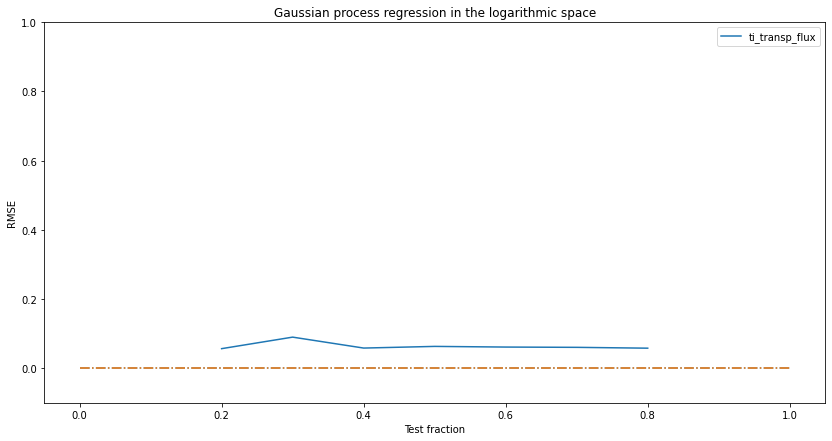

In [20]:
plt.figure(figsize=(14,7))
plt.plot([S[s]['trF'] for s in np.sort(list(S.keys()))] , [S[s]['RMSE'] for s in np.sort(list(S.keys()))])
plt.xlabel('Test fraction') ; plt.ylabel('RMSE') ; plt.ylim(-0.1,1)
plt.legend(loc=0, labels=YLABELS)
plt.gca().set_prop_cycle(None)
plt.plot([0, 1], np.broadcast_to(RMSE, (2,2)), '-.' )
plt.title('Gaussian process regression in the logarithmic space');

#### GPR: effects from differing training fractions --- plot of VarianceScore

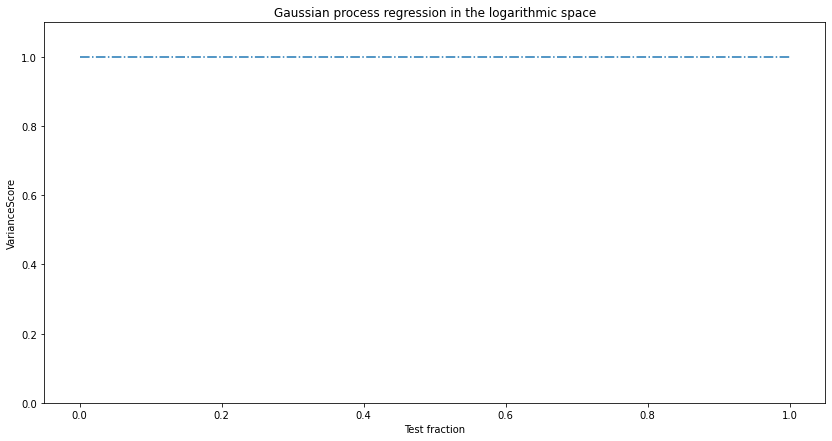

In [21]:
plt.figure(figsize=(14,7))
plt.plot([S[s]['trF'] for s in np.sort(list(S.keys()))] , [S[s]['VarianceScore'] for s in np.sort(list(S.keys()))])
plt.xlabel('Test fraction') ; plt.ylabel('VarianceScore') ; plt.ylim(0,1.1)
plt.gca().set_prop_cycle(None)
plt.plot([0, 1], [VarianceScore, VarianceScore], '-.' )
plt.title('Gaussian process regression in the logarithmic space');

### ADDITION: HYPERPARAMETER SCAN with scikit-learn tuner

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import RBF, Matern

In [24]:
GaussianProcessRegressor().get_params().keys()

dict_keys(['alpha', 'copy_X_train', 'kernel', 'n_restarts_optimizer', 'normalize_y', 'optimizer', 'random_state'])

In [41]:
test_fractions = [0.80, 0.70, 0.60, 0.50, 0.40, 0.30, 0.20]
tf = test_fractions[3]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=tf, random_state=0)

In [105]:
"""
hyperameters_vary = [
    {"kernel": ["rbf"], "length_scale":[.1, 1., 10.]},
    {"kernel":["matern"], "length_scale":[.1, 1., 10.]},
]
"""

kernel_name_dict = {
    "rbf": RBF(),
    "matern": Matern(),
    "composite": ConstantKernel() * Matern() + WhiteKernel(),
}

kernel_dict = {
            "rbf": {"length_scale": [0.01, 0.1, 1.]}, 
            "matern": {"length_scale": [0.01, 0.1, 1.]},
            "composite": {"k1__k1__constant_value": [0.01, 0.1, 1.], "k1__k2__length_scale": [0.01, 0.1, 1.], "k2__noise_level": [0.01, 0.1, 1.0]},
}

score_names = ["r2", "explained_variance"]

In [106]:
models = {}
score_vals = {}

#reg = GridSearchCV(GaussianProcessRegressor(), hyperameters_vary, scoring="r2")
#reg.fit(X_train, y_train)

# Iterate over different types of kernels
for k_name in kernel_dict.keys():

    # Store default values for kernel parameters
    kernel_params_conc = {}
    #for k,v in kernel_dict[k_name].items():
    #    # As default take first element of each parameter value list
    #    kernel_params_conc[k] = v[0]

    ## Change the parameter values: iterate over parameters
    #for par in kernel_dict[k_name].keys():
    # Iterate over carthesian product of all possible kernel parameter values
    for par_val in itertools.product(*kernel_dict[k_name].values()):
        #print(par_val) #DEBUG

        ## Assign parameter dictionary default value for non-running variable
        #kernel_params_conc[par] = kernel_dict[k_name][par][0]
        
        ## Iterate over possible values for chosen parameter 
        ##for val in kernel_dict[k_name][par]:
        
        for i, k in enumerate(kernel_dict[k_name].keys()):
            kernel_params_conc[k] = par_val[i]

        #print(kernel_params_conc) #DEBUG
        #print(kernel_name_dict[k_name].get_params().keys()) #DEBUG

        # Set the parameters of kernel object from the dictionary, create model and fit it
        kernel = kernel_name_dict[k_name].set_params(**kernel_params_conc)
        reg = GaussianProcessRegressor(kernel=kernel)
        reg.fit(X_train, y_train)
        
        # Save parameter values as a dictionary key and store the model
        model_key = k_name
        for (k,v) in kernel_params_conc.items():
            model_key += '_' + k + '_' + str(v)
        models[model_key] = reg

        # Save R2 scores on test set for each model 
        sc = reg.score(X_test, y_test)
        score_vals[model_key] = sc
        print('The model with initial kernel of {0} has {1} score={2}'.format(model_key, score_names[0], str(sc)))

best_param = max(score_vals.items(), key=operator.itemgetter(1))[0]

print('')
print('>>> Best parameter values out of tested ones is {0} with score of {1}'.format(best_param, score_vals[best_param]))
print('>>> Its parameters are: {0}'.format(models[best_param].kernel_))

#print(score_vals) #DEBUG



The model with initial kernel of rbf_length_scale_0.01 has r2 score=7.35710895404369e-01
The model with initial kernel of rbf_length_scale_0.1 has r2 score=7.357108953840408e-01
The model with initial kernel of rbf_length_scale_1.0 has r2 score=-1.2438858001987071e+04
The model with initial kernel of matern_length_scale_0.01 has r2 score=7.838170764043274e-01
The model with initial kernel of matern_length_scale_0.1 has r2 score=7.838170865962363e-01
The model with initial kernel of matern_length_scale_1.0 has r2 score=7.838170759972596e-01
The model with initial kernel of composite_k1__k1__constant_value_0.01_k1__k2__length_scale_0.01_k2__noise_level_0.01 has r2 score=-5.3444941516447964e-02
The model with initial kernel of composite_k1__k1__constant_value_0.01_k1__k2__length_scale_0.01_k2__noise_level_0.1 has r2 score=7.605557856772036e-01
The model with initial kernel of composite_k1__k1__constant_value_0.01_k1__k2__length_scale_0.01_k2__noise_level_1.0 has r2 score=-1.24388069231592

/u/yyudin/conda-envs/python394/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/u/yyudin/conda-envs/python394/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1e+05. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


The model with initial kernel of composite_k1__k1__constant_value_0.01_k1__k2__length_scale_1.0_k2__noise_level_0.01 has r2 score=-5.3444940037459476e-02
The model with initial kernel of composite_k1__k1__constant_value_0.01_k1__k2__length_scale_1.0_k2__noise_level_0.1 has r2 score=7.605557558281816e-01
The model with initial kernel of composite_k1__k1__constant_value_0.01_k1__k2__length_scale_1.0_k2__noise_level_1.0 has r2 score=7.605558319074356e-01
The model with initial kernel of composite_k1__k1__constant_value_0.1_k1__k2__length_scale_0.01_k2__noise_level_0.01 has r2 score=-5.344494084015228e-02
The model with initial kernel of composite_k1__k1__constant_value_0.1_k1__k2__length_scale_0.01_k2__noise_level_0.1 has r2 score=7.605558529091416e-01
The model with initial kernel of composite_k1__k1__constant_value_0.1_k1__k2__length_scale_0.01_k2__noise_level_1.0 has r2 score=-5.3444934448626746e-02
The model with initial kernel of composite_k1__k1__constant_value_0.1_k1__k2__length_sc

/u/yyudin/conda-envs/python394/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1e+05. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/u/yyudin/conda-envs/python394/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1e+05. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



The model with initial kernel of composite_k1__k1__constant_value_0.1_k1__k2__length_scale_1.0_k2__noise_level_0.01 has r2 score=7.605562720603903e-01
The model with initial kernel of composite_k1__k1__constant_value_0.1_k1__k2__length_scale_1.0_k2__noise_level_0.1 has r2 score=7.605558902765635e-01
The model with initial kernel of composite_k1__k1__constant_value_0.1_k1__k2__length_scale_1.0_k2__noise_level_1.0 has r2 score=7.605557764379401e-01
The model with initial kernel of composite_k1__k1__constant_value_1.0_k1__k2__length_scale_0.01_k2__noise_level_0.01 has r2 score=-5.3444849725749144e-02
The model with initial kernel of composite_k1__k1__constant_value_1.0_k1__k2__length_scale_0.01_k2__noise_level_0.1 has r2 score=7.605558344739282e-01
The model with initial kernel of composite_k1__k1__constant_value_1.0_k1__k2__length_scale_0.01_k2__noise_level_1.0 has r2 score=-5.344407935068696e-02
The model with initial kernel of composite_k1__k1__constant_value_1.0_k1__k2__length_scale_

In [ ]:
NX = len(XLABELS)
NY = len(YLABELS)
print('Number of points = ', X.shape[0])

model_cur = models[best_param]

Xt = X_test.copy()
Yt = np.zeros((Xt.shape[0],NY))
Yts = np.zeros((Xt.shape[0],NY))
for F in range(NY):
  Yt[:,F], Yts[:,F] = model_cur.predict(Xt, return_std=True)

Xvals = np.array([np.unique(X[:,i]) for i in range(X.shape[1])])

plt.figure(figsize=(27,12))
for i in range(NX):
    ax=plt.subplot(2,2,i+1)
    #vis(i, ax)
    vis2(i, ax)
plt.subplots_adjust(hspace=0.4)

### Linear regression

In [ ]:
reg = linear_model.LinearRegression(n_jobs=-1)
reg.fit (X, Y)
Y_pred = reg.predict(X)
print("Mean squared error: %.3f" % mean_squared_error(Y, Y_pred))
RMSE = np.sqrt(mean_squared_error(Y, Y_pred, multioutput='raw_values'))
print("RMSE ", RMSE)
# Explained variance score: 1 is perfect prediction
VarianceScore = r2_score(Y, Y_pred)
print('Variance score: %.3f' % VarianceScore)
L.append(['Linear', RMSE, VarianceScore])
print(L[-1])

### Linear regression: effects from differing training fractions

In [ ]:
S={}
for trF in [0.99, 0.98, 0.95, 0.90, 0.80, 0.70, 0.60, 0.50, 0.40, 0.30, 0.20, 0.10, 0.05, 0.02, 0.01]:
    S[str(trF)] = {}
    S[str(trF)]['trF'] = trF
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X, Y, test_size=trF)
    reg = linear_model.LinearRegression(n_jobs=-1)
    reg.fit (X_trn, Y_trn)
    Y_pred = reg.predict(X_tst)
    S[str(trF)]['RMSE'] = np.sqrt(mean_squared_error(Y_tst, Y_pred, multioutput='raw_values'))
    S[str(trF)]['VarianceScore'] = r2_score(Y_tst, Y_pred)

### Linear regression: effects from differing training fractions --- plot of RMSE

In [ ]:
plt.figure(figsize=(14,7))
plt.plot([S[s]['trF'] for s in np.sort(list(S.keys()))] , [S[s]['RMSE'] for s in np.sort(list(S.keys()))] )
plt.xlabel('Test fraction') ; plt.ylabel('RMSE') ; plt.ylim(0,1)
plt.legend(loc=0, labels=YLABELS)
plt.gca().set_prop_cycle(None)
plt.plot([0, 1] , np.broadcast_to(RMSE, (2,2)), '-.' )
plt.title('Linear regression in the logarithmic space');

### Ridge linear regression

In [ ]:
reg = linear_model.Ridge (alpha = 0.5)
reg.fit (X, Y)
Y_pred = reg.predict(X)
print("Mean squared error: %.3f" % mean_squared_error(Y, Y_pred))
RMSE = np.sqrt(mean_squared_error(Y, Y_pred, multioutput='raw_values'))
print("RMSE ", RMSE)
# Explained variance score: 1 is perfect prediction
VarianceScore = r2_score(Y, Y_pred)
print('Variance score: %.3f' % VarianceScore)
L.append(['Ridge', RMSE, VarianceScore])
print(L[-1])

### RidgeCV linear regression

In [ ]:
reg = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0])
reg.fit (X, Y)
Y_pred = reg.predict(X)
print("Mean squared error: %.3f" % mean_squared_error(Y, Y_pred))
RMSE = np.sqrt(mean_squared_error(Y, Y_pred, multioutput='raw_values'))
print("RMSE ", RMSE)
# Explained variance score: 1 is perfect prediction
VarianceScore = r2_score(Y, Y_pred)
print('Variance score: %.3f' % VarianceScore)
L.append(['RidgeCV', RMSE, VarianceScore])
print(L[-1])

### Lasso linear regression

In [ ]:
reg = linear_model.Lasso(alpha = 1e-6)
reg.fit (X, Y)
Y_pred = reg.predict(X)
print("Mean squared error: %.3f" % mean_squared_error(Y, Y_pred))
RMSE = np.sqrt(mean_squared_error(Y, Y_pred, multioutput='raw_values'))
print("RMSE ", RMSE)
# Explained variance score: 1 is perfect prediction
VarianceScore = r2_score(Y, Y_pred)
print('Variance score: %.3f' % VarianceScore)
L.append(['Lasso', RMSE, VarianceScore])
print(L[-1])

### Bayesian ridge linear regression

In [ ]:
reg = linear_model.BayesianRidge()
Y_pred = np.zeros_like(Y)
for F in range(Y.shape[1]):  reg.fit (X, Y[:,F]) ; Y_pred[:,F] = reg.predict(X)
print("Mean squared error: %.3f" % mean_squared_error(Y, Y_pred))
RMSE = np.sqrt(mean_squared_error(Y, Y_pred, multioutput='raw_values'))
print("RMSE ", RMSE)
# Explained variance score: 1 is perfect prediction
VarianceScore = r2_score(Y, Y_pred)
print('Variance score: %.3f' % VarianceScore)
L.append(['BayesianRidge', RMSE, VarianceScore])
print(L[-1])

### SVM SVR 

In [ ]:
Y_pred = np.zeros_like(Y)
for F in range(Y.shape[1]): 
    model = Pipeline([('poly', PolynomialFeatures(degree=1, include_bias=False)), ('svm', svm.SVR(kernel='rbf'))])
    RES = model.fit(X, Y[:,F]) ; Y_pred[:,F] = RES.predict(X)
print("Mean squared error: %.3f" % mean_squared_error(Y, Y_pred))
RMSE = np.sqrt(mean_squared_error(Y, Y_pred, multioutput='raw_values'))
print("RMSE ", RMSE)
# Explained variance score: 1 is perfect prediction
VarianceScore = r2_score(Y, Y_pred)
print('Variance score: %.3f' % VarianceScore)
L.append(['SVR', RMSE, VarianceScore])
print(L[-1])

### SVM nuSVR 

In [ ]:
Y_pred = np.zeros_like(Y)
for F in range(Y.shape[1]): 
    model = Pipeline([('poly', PolynomialFeatures(degree=1, include_bias=False)), ('svm', svm.NuSVR(kernel='rbf'))])
    RES = model.fit(X, Y[:,F]) ; Y_pred[:,F] = RES.predict(X)
print("Mean squared error: %.3f" % mean_squared_error(Y, Y_pred))
RMSE = np.sqrt(mean_squared_error(Y, Y_pred, multioutput='raw_values'))
print("RMSE ", RMSE)
# Explained variance score: 1 is perfect prediction
VarianceScore = r2_score(Y, Y_pred)
print('Variance score: %.3f' % VarianceScore)
L.append(['NuSVR', RMSE, VarianceScore])
print(L[-1])

### SVM SVR (C=1, gamma=1)

In [ ]:
Y_pred = np.zeros_like(Y)
for F in range(Y.shape[1]): 
    model = Pipeline([('poly', PolynomialFeatures(degree=1, include_bias=False)), ('svm', svm.SVR(C=1, gamma=1, kernel='rbf'))])
    RES = model.fit(X, Y[:,F]) ; Y_pred[:,F] = RES.predict(X)
print("Mean squared error: %.3f" % mean_squared_error(Y, Y_pred))
RMSE = np.sqrt(mean_squared_error(Y, Y_pred, multioutput='raw_values'))
print("RMSE ", RMSE)
# Explained variance score: 1 is perfect prediction
VarianceScore = r2_score(Y, Y_pred)
print('Variance score: %.3f' % VarianceScore)
L.append(['SVR(C=1,gamma=1)', RMSE, VarianceScore])
print(L[-1])

### Multivariate polynomial regression

In [ ]:
S={}
for i in range(13):  #13
    S[i]={}
    model = Pipeline([('poly', PolynomialFeatures(degree=i+1)), ('linear', RidgeCV(alphas=[0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0, 100.0], fit_intercept=False))])
    RES = model.fit(X, Y)
    S[i]['RES'] = RES
    S[i]['alpha'] = RES.named_steps['linear'].alpha_
    S[i]['coef'] = RES.named_steps['linear'].coef_
    S[i]['intercept'] = RES.named_steps['linear'].intercept_
    Y_pred = RES.predict(X)
    S[i]['degree'] = i+1
    print('Polynomial of degree ', i+1)
    S[i]['MSE'] = mean_squared_error(Y, Y_pred)
    print("Mean squared error: %.3f" % mean_squared_error(Y, Y_pred))
    S[i]['VarianceScore'] = r2_score(Y, Y_pred)
    print('Variance score: %.3f' % r2_score(Y, Y_pred))
    S[i]['RMSE'] = np.sqrt(mean_squared_error(Y, Y_pred, multioutput='raw_values'))
    print("RMSE ", np.sqrt(mean_squared_error(Y, Y_pred, multioutput='raw_values')))

### Multivariate polynomial regression: RMSE vs degree

In [ ]:
plt.figure(figsize=(14,7))
plt.plot([S[s]['degree'] for s in np.sort(list(S.keys()))] , [S[s]['RMSE'] for s in np.sort(list(S.keys()))] )
plt.xlabel('Degree') ; plt.ylabel('RMSE') ; plt.ylim(0,1)
plt.legend(loc=0, labels=YLABELS)
plt.title('RidgeCV regression with polynomial extension\nin the logarithmic space')

### Multivariate polynomial regression: effect of training fraction

In [ ]:
for C in S:
    print('degree ', S[C]['degree'])
    S2={}
    for trF in [0.99, 0.98, 0.95, 0.90, 0.80, 0.70, 0.60, 0.50, 0.40, 0.30, 0.20, 0.10, 0.05, 0.02, 0.01]:
        S2[str(trF)] = {}
        S2[str(trF)]['trF'] = trF
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X, Y, test_size=trF)
        model = Pipeline([('poly', PolynomialFeatures(degree=S[C]['degree'])), ('linear', RidgeCV(alphas=[0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0, 100.0], fit_intercept=False))])
        RES = model.fit(X_trn, Y_trn)
        Y_pred = RES.predict(X_tst)
        S2[str(trF)]['RMSE'] = np.sqrt(mean_squared_error(Y_tst, Y_pred, multioutput='raw_values'))
        S2[str(trF)]['VarianceScore'] = r2_score(Y_tst, Y_pred)

    plt.figure(figsize=(14,7))
    plt.plot([S2[s]['trF'] for s in np.sort(list(S2.keys()))] , [S2[s]['RMSE'] for s in np.sort(list(S2.keys()))] )
    plt.xlabel('Test fraction') ; plt.ylabel('RMSE') ; plt.ylim(0,1)
    plt.legend(loc=0, labels=YLABELS)
    plt.gca().set_prop_cycle(None)
    plt.plot([0, 1] , np.broadcast_to(S[C]['RMSE'], (2,2)), '-.' )
    plt.title('RidgeCV regression with polynomial extension %s\nin the normalised logarithmic space' % (S[C]['degree']));

## Summary of results

In [ ]:
LL = []
for l in L:
    LLL=[] ; LLL.append(l[0]) ; LLL.extend(l[1]) ; LLL.append(l[2])
    LL.append(LLL)
for s in S: 
    SSS=[] ; SSS.append('RidgeCV_with_polynomial_extension=%s' % S[s]['degree'])
    SSS.extend(S[s]['RMSE']) ; SSS.append(S[s]['VarianceScore'])
    LL.append(SSS)
headers=['method'] ; headers.extend(YLABELS) ; headers.append('VarianceScore')
print(tabulate.tabulate(LL, tablefmt="simple", headers=headers, floatfmt='5.3f'))